In [1]:
from skimage.transform import resize
import numpy as np
from itertools import product
from collections import OrderedDict
import os
from tqdm.notebook import tqdm
#from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

from Run import RunBuilder as RB
from Run import RunManager as RM
from DataLoading import UdacityDataset as UD
from DataLoading import ConsecutiveBatchSampler as CB

from model import TransferLearning as TL

%run Visualization/Visualization.ipynb

torch.set_printoptions(linewidth=120) 
device = torch.device("cuda:0")

# Model Training / Loading

In [2]:
parameters = OrderedDict(
    learning_rate = [0.001],
    batch_size = [50],
    num_workers = [1],
    #shuffle = [True,False]
)

m = RM.RunManager()
for run in RB.RunBuilder.get_runs(parameters):
    network = TL.TLearning()
    network.cuda()
    network.to(device)
    optimizer = optim.Adam(network.parameters(),lr = run.learning_rate,betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001/run.batch_size, amsgrad=False)
# modify the time to visible time format, also use it to check the sequency of pictures is from former to current
    udacity_dataset = UD.UdacityDataset(csv_file='/home/kxk190041/data/self_driving/train/interpolated.csv',
                                     root_dir='/home/kxk190041/data/self_driving/train/',
                                     transform=transforms.Compose([transforms.ToTensor()]),
                                     select_camera='center_camera')
    dataset_size = int(len(udacity_dataset))
    del udacity_dataset
    split_point = int(dataset_size * 0.8)

    training_set = UD.UdacityDataset(csv_file='/home/kxk190041/data/self_driving/train/interpolated.csv',
                                     root_dir='/home/kxk190041/data/self_driving/train/',
                                     transform=transforms.Compose([transforms.ToTensor()]),
                                     select_camera='center_camera',
                                     select_range=(0,split_point))

    validation_set = UD.UdacityDataset(csv_file='/home/kxk190041/data/self_driving/train/interpolated.csv',
                                     root_dir='/home/kxk190041/data/self_driving/train/',
                                     transform=transforms.Compose([transforms.ToTensor()]),
                                     select_camera='center_camera',
                                     select_range=(split_point,dataset_size))
    print("size of training set :{}".format(len(training_set)))
    print("size of validation set :{}".format(len(validation_set)))
    
    training_cbs = CB.ConsecutiveBatchSampler(data_source=training_set, batch_size=run.batch_size, shuffle=True, drop_last=False, seq_len=1)
    training_loader = DataLoader(training_set, sampler=training_cbs, num_workers=run.num_workers, collate_fn=(lambda x: x[0]))

    validation_cbs = CB.ConsecutiveBatchSampler(data_source=validation_set, batch_size=run.batch_size, shuffle=True, drop_last=False, seq_len=1)
    validation_loader = DataLoader(validation_set, sampler=validation_cbs, num_workers=run.num_workers, collate_fn=(lambda x: x[0]))

    training_time = 0

    m.begin_run( run,network,[run.batch_size,3,224,224] )
    for epoch in range(10):
        st_time = time.time()
        m.begin_epoch()
        
        for training_sample in tqdm(training_loader):
            training_sample['image'] = training_sample['image'].squeeze()
            training_sample['image'] = torch.Tensor(resize(training_sample['image'], (run.batch_size,3,224,224),anti_aliasing=True))
            param_values = [v for v in training_sample.values()]
            image,angle = param_values[0],param_values[3]
            image = image.to(device)
            #print(image.dtype)
            #image = image.to(torch.float)
            prediction = network(image)
            prediction = prediction.to(device)
            labels = angle.to(device)
            labels = labels.to(torch.float)
            del param_values, image, angle
            if labels.shape[0]!=prediction.shape[0]:
                prediction = prediction[-labels.shape[0],:]
            training_loss_angle = F.mse_loss(prediction,labels,size_average=None, reduce=None, reduction='mean')
            optimizer.zero_grad()# zero the gradient that are being held in the Grad attribute of the weights
            training_loss_angle.backward() # calculate the gradients
            optimizer.step() # finishing calculation on gradient 
        print("Done")
        training_time += (time.time() - st_time) 
# Calculation on Validation Loss
        with torch.no_grad():    
            for Validation_sample in tqdm(validation_loader):
                Validation_sample['image'] = Validation_sample['image'].squeeze()
                Validation_sample['image'] = torch.Tensor(resize(Validation_sample['image'], (run.batch_size,3,224,224),anti_aliasing=True))

                param_values = [v for v in Validation_sample.values()]
                image,angle = param_values[0],param_values[3]
                image = image.to(device)
                prediction = network(image)
                prediction = prediction.to(device)
                labels = angle.to(device)
                labels = labels.to(torch.float)
                del param_values, image, angle
                if labels.shape[0]!=prediction.shape[0]:
                    prediction = prediction[-labels.shape[0],:]
                validation_loss_angle = F.mse_loss(prediction,labels,size_average=None, reduce=None, reduction='mean')
                m.track_loss(validation_loss_angle, labels.shape[0])
                m.track_num_correct(prediction,labels) 
        m.end_epoch()
        torch.save(network.state_dict(), "/home/kxk190041/Self-Driving-Car/results/Angle_Adam_MSE_Paper_Model-epoch-{}".format(epoch))
    m.end_run()
m.save('result_resnet')
print('Training time taken: ', training_time)

,run,epoch,loss,accuracy,epoch duration,run duration,learning_rate,batch_size,num_workers
0,1,1,0.027603,0.740741,1565.918462,1565.923082,0.001,50,1
1,1,2,0.025640,0.733333,1671.578668,3244.837650,0.001,50,1
2,1,3,0.011185,0.740741,1737.606304,4990.006188,0.001,50,1
3,1,4,0.005292,0.740741,1674.849258,6671.992882,0.001,50,1
4,1,5,0.011063,0.740741,1672.579952,8351.340681,0.001,50,1
5,1,6,0.009278,0.733333,1564.687611,9922.726559,0.001,50,1
6,1,7,0.005580,0.740741,1612.566890,11541.562150,0.001,50,1
7,1,8,0.003248,0.740741,1588.288040,13135.843143,0.001,50,1
8,1,9,0.005084,0.740741,1557.818054,14699.790065,0.001,50,1
9,1,10,0.004656,0.733333,1563.742467,16269.328845,0.001,50,1


Training time taken:  13112.848578453064


Training time taken:  13112.848578453064


In [4]:
# Load Directly from disk

tl_model = TL.TLearning().to(device)
tl_model.load_state_dict(torch.load('/home/kxk190041/Self-Driving-Car/results/Angle_Adam_MSE_Paper_Model-epoch-9'))

<All keys matched successfully>

# Visualization

(64, 3, 7, 7)


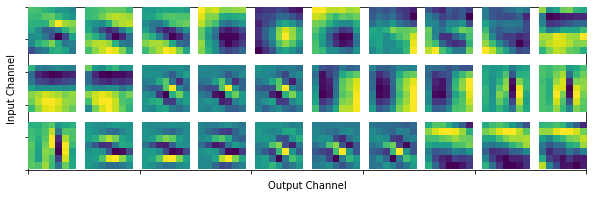

In [5]:
visualize_cnn(tl_model.ResNet.conv1)

### GradCAM

/home/kxk190041/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


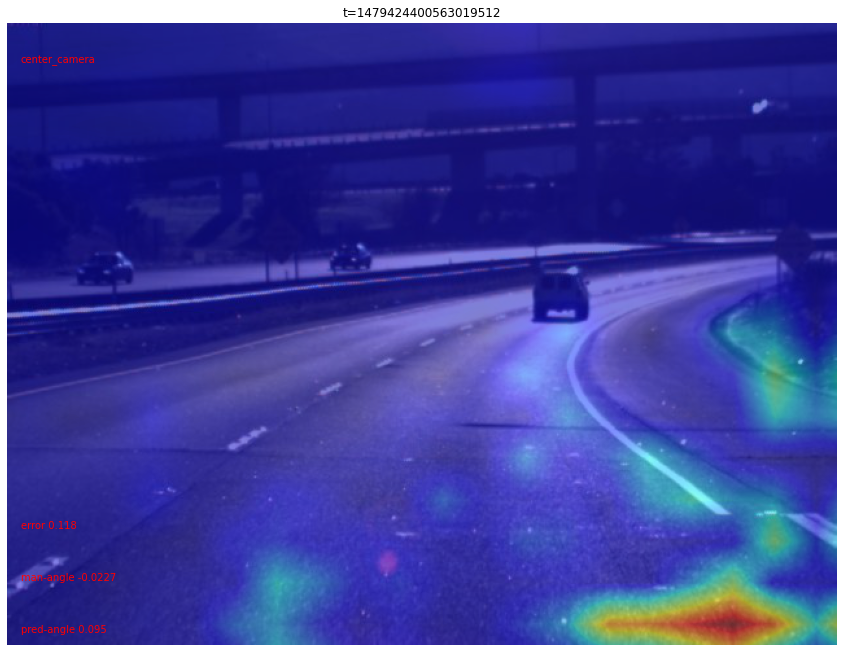

In [6]:
import copy

udacity_dataset = UD.UdacityDataset(csv_file='/home/kxk190041/data/self_driving/train/interpolated.csv',
                                 root_dir='/home/kxk190041/data/self_driving/train/',
                                 transform=transforms.Compose([transforms.ToTensor()]),
                                 select_camera='center_camera')


# Load arbitrary data
sample = udacity_dataset[3693]
sample_1 = copy.deepcopy(sample)
sample_1['image'] = sample_1['image'].reshape(-1, 3, 480, 640)
input_image = sample['image'].reshape(-1, 3, 480, 640).cuda()

cam_extractor_tl = CamExtractorTLModel(tl_model)

# Forward pass
model_output = tl_model(input_image)
show_sample(sample_1, model_output.item())
# Backward pass
tl_model.zero_grad()
mse_loss = nn.MSELoss()
loss = mse_loss(model_output, sample['angle'].to(torch.float).cuda().reshape(1,1))
loss.backward()

cam_image = cam_extractor_tl.to_image(height=480, width=640) # Use this line to extract CAM image from the model!
plt.imshow(cam_image[0, :, :], cmap='jet', alpha=0.5) # this shows CAM as overlay to the original input image
